# 🔍 Domain-Specific Q&A Using RAG (Retrieval-Augmented Generation)
## AI/Machine Learning Domain
 
**Course:** Applied Natural Language Processing — Semester Project  
**Date:** February 2026  
**Runtime:** Google Colab (Free Tier)

---

## 1. Introduction

### Objective
Build a complete **Retrieval-Augmented Generation (RAG)** pipeline for answering technical questions in the **AI/Machine Learning** domain. The system ingests academic PDFs, creates a searchable vector store, retrieves relevant passages for a given query, and uses a language model to generate accurate, context-grounded answers.

### Why RAG?
Standard language models generate answers from their parametric memory (training data), which can lead to hallucinations or outdated information. RAG addresses this by **retrieving relevant documents first**, then feeding them as context to the generator — grounding the answer in actual source material.

### Domain & Knowledge Base
We use **6 PDF documents** covering core AI/ML topics:

| # | Document | Description |
|---|----------|-------------|
| 1 | `attention_is_all_you_need.pdf` | Original Transformer paper (Vaswani et al., 2017) |
| 2 | `cnn_transformers_intro.pdf` | Introduction to CNNs and Transformers |
| 3 | `cs224n_merged_notes.pdf` | Stanford CS224N (NLP) merged lecture notes |
| 4 | `cs224n_transformers_2024.pdf` | CS224N Transformers lecture (2024 edition) |
| 5 | `cs231n_full_notes.pdf` | Stanford CS231N (Computer Vision) full notes |
| 6 | `neural_networks_backprop.pdf` | Neural networks & backpropagation notes |

### Pipeline Architecture

```
┌─────────────┐    ┌──────────────┐    ┌────────────┐    ┌────────────────┐
│  6 AI/ML    │───▶│ Text Extract │───▶│  Chunking  │───▶│  Embedding     │
│  PDFs       │    │ + Cleaning   │    │ (500 tok,  │    │ (MiniLM-L6-v2) │
└─────────────┘    └──────────────┘    │ 50 overlap)│    │  384-dim       │
                                       └────────────┘    └───────┬────────┘
                                                                 │
                                                                 ▼
┌─────────────┐    ┌──────────────┐    ┌────────────┐    ┌────────────────┐
│  Generated  │◀───│  FLAN-T5     │◀───│  Prompt    │◀───│  FAISS Index   │
│  Answer     │    │  -large      │    │  Building  │    │  (Flat L2)     │
└─────────────┘    └──────────────┘    └────────────┘    └────────────────┘
                                            ▲
                                            │
                                       ┌────────────┐
                                       │  User      │
                                       │  Query     │
                                       └────────────┘
```

**Flow:** PDFs → Extract Text → Clean → Chunk → Embed → Store in FAISS → User asks question → Embed query → Retrieve top-k chunks → Build prompt with context → FLAN-T5-large generates answer

## 2. Methodology

### Pipeline Stages

Our RAG system operates in **7 sequential stages**:

1. **PDF Text Extraction** — Read raw text from each PDF page using PyPDF2
2. **Text Cleaning** — Remove excess whitespace, fix encoding artifacts, normalize formatting
3. **Chunking** — Split cleaned text into overlapping chunks (~500 tokens, 50 token overlap) with source metadata
4. **Embedding Generation** — Encode each chunk into a 384-dimensional dense vector using `all-MiniLM-L6-v2`
5. **FAISS Indexing** — Store all embeddings in a FAISS flat L2 index for exact nearest-neighbor search
6. **Retrieval** — Given a user query, embed it and retrieve the top-k most similar chunks from the index
7. **Generation** — Feed retrieved chunks as context into a prompt template, then generate an answer using FLAN-T5-large

### Model Choices & Justification

| Component | Model / Tool | Justification |
|-----------|-------------|---------------|
| Embeddings | `all-MiniLM-L6-v2` | Fast, 384-dim, excellent quality-to-size ratio, fits Colab free tier |
| Vector Store | FAISS `IndexFlatL2` | Exact search (no approximation error), dataset is small enough, simple to explain |
| Generator | `google/flan-t5-large` (~780M params) | Instruction-tuned, runs on T4 GPU, good at following prompt templates |
| PDF Parsing | PyPDF2 | Lightweight, no system dependencies, handles standard academic PDFs |

### Evaluation Plan

We compare **RAG answers** vs. **Baseline answers** (no retrieval) on 8–10 domain-specific questions using:

- **ROUGE-L** — Measures longest common subsequence overlap with reference answers (lexical similarity)
- **Cosine Semantic Similarity** — Uses MiniLM embeddings to measure meaning-level similarity with reference answers

This dual evaluation captures both surface-level word overlap and deeper semantic alignment.

## 3. Implementation

### Step 1: Environment Setup
First, we mount Google Drive to access our dataset (the PDFs).

In [56]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Step 2: Directory Configuration
Define the project path and create the `data` directory if it doesn't exist. This is where our PDFs should be stored.

In [57]:
import os

PROJECT_PATH = "/content/drive/MyDrive/rag_project"
DATA_PATH = os.path.join(PROJECT_PATH, "data")

os.makedirs(DATA_PATH, exist_ok=True)

print("Project directory created at:", PROJECT_PATH)

Project directory created at: /content/drive/MyDrive/rag_project


### Step 3: Verify Data Files
List the files in the `data` folder to ensure our PDFs are present and accessible.

In [58]:
import os

print("Files in data folder:")
print(os.listdir(DATA_PATH))

Files in data folder:
['cs231n_full_notes.pdf', 'cnn_transformers_intro.pdf', 'cs224n_transformers_2024.pdf', 'attention_is_all_you_need.pdf', 'cs224n_merged_notes.pdf', 'neural_networks_backprop.pdf']


### Step 4: Install Dependencies
Install all required Python libraries using pip. Here is what each package does:

| Package | Purpose |
|---------|---------|
| `PyPDF2` | Extract text from PDF files page by page |
| `sentence-transformers` | Load the MiniLM embedding model to encode text into vectors |
| `faiss-cpu` | Facebook AI Similarity Search — fast vector index for retrieval |
| `transformers` | Load the FLAN-T5-large language model for answer generation |
| `rouge-score` | Compute ROUGE-L evaluation metric |
| `torch` | Deep learning backend for running the models |
| `pandas` | Tabular data handling for evaluation results |
| `matplotlib` / `seaborn` | Visualization of evaluation metrics |

In [59]:
%pip install -q PyPDF2 sentence-transformers faiss-cpu transformers rouge-score torch pandas matplotlib seaborn

### Step 5: Import Libraries
Import all required modules and configure global settings:
- **`torch`** — GPU/CPU detection and tensor operations
- **`faiss`** — Vector similarity search
- **`numpy` / `pandas`** — Numerical computing and data handling
- **`re`** — Regular expressions for text cleaning
- **`matplotlib` / `seaborn`** — Plotting evaluation charts
- **`PyPDF2.PdfReader`** — PDF text extraction
- **`SentenceTransformer`** — Pre-trained MiniLM embedding model
- **`AutoTokenizer` / `AutoModelForSeq2SeqLM`** — FLAN-T5-large tokenizer and model
- **`rouge_scorer`** — ROUGE-L metric computation
- **`cosine_similarity`** — Cosine similarity for semantic evaluation

In [60]:
import torch
import faiss
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

### Step 6: Data Ingestion (PDF Parsing)
Iterate through all PDF files in the data directory, extract text page by page using `PyPDF2`, and store the raw text along with source metadata (filename and page number).

In [61]:
documents = []

for file in os.listdir(DATA_PATH):
    if file.endswith(".pdf"):
        reader = PdfReader(os.path.join(DATA_PATH, file))
        for page_num, page in enumerate(reader.pages):
            text = page.extract_text()
            if text:
                documents.append({
                    "source": file,
                    "page": page_num,
                    "text": text
                })

print("Total pages loaded:", len(documents))

Total pages loaded: 594


### Step 7: Text Cleaning
Define a function to clean the extracted text by removing excessive newlines, extra spaces, and hyphenation artifacts. Apply this to all loaded pages.

In [62]:
def clean_text(text):
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'-\s+', '', text)
    return text.strip()

for doc in documents:
    doc["text"] = clean_text(doc["text"])

print("Sample cleaned text:\n")
print(documents[0]["text"][:500])

Sample cleaned text:

DEEP LEARNING STUDY NOTES All credits go to L. Fei-Fei, A. Karpathy, J.Johnson teachers of the CS231n course. Thank you for this amazing course!! by Albert Pumarola


### Step 8: Text Chunking
Split the cleaned text into smaller, overlapping chunks. This is crucial for RAG because we want to retrieve specific, relevant passages rather than entire pages. We also include a heuristic filter to drop noisy chunks (e.g., OCR errors or tables with few alphabetical characters).

In [63]:
# ================================
# CHUNKING WITH TOKEN-AWARE SIZING
# ================================

def chunk_text(text, chunk_size=220, overlap=40):
    """Split text into overlapping word chunks with conservative size."""
    words = text.split()
    word_chunk_size = max(80, int(chunk_size * 0.75))
    word_overlap = max(15, int(overlap * 0.75))
    step = max(1, word_chunk_size - word_overlap)

    chunks = []
    for i in range(0, len(words), step):
        chunk = " ".join(words[i:i + word_chunk_size]).strip()
        if len(chunk.split()) >= 35:
            chunks.append(chunk)
    return chunks


def is_noisy_chunk(chunk):
    """Heuristic filter to drop OCR-heavy/noise-heavy chunks."""
    alpha_chars = sum(ch.isalpha() for ch in chunk)
    char_ratio = alpha_chars / max(len(chunk), 1)
    return char_ratio < 0.65


all_chunks = []
chunk_metadata = []

for doc in documents:
    chunks = chunk_text(doc["text"], chunk_size=220, overlap=40)
    for i, chunk in enumerate(chunks):
        if is_noisy_chunk(chunk):
            continue
        all_chunks.append(chunk)
        chunk_metadata.append({
            "source": doc["source"],
            "page": doc["page"],
            "chunk_id": i
        })

print(f"✓ Total chunks created: {len(all_chunks)}")
print(f"  Average chunk length: {np.mean([len(c.split()) for c in all_chunks]):.0f} words")
print(f"  Sample chunk preview: {all_chunks[0][:200]}...")

✓ Total chunks created: 695
  Average chunk length: 122 words
  Sample chunk preview: Chapter 1 Data Preprocessing There are di erent techniques used in learning in order to improve the accuracy of the model by preprocessing the data: There are three common forms of data preprocessing ...


### Step 9: Generate Embeddings
Use the `all-MiniLM-L6-v2` model from SentenceTransformers to convert our text chunks into dense vector embeddings (384 dimensions). These embeddings capture the semantic meaning of the text.

In [64]:
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

chunk_embeddings = embedding_model.encode(
    all_chunks,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Embedding matrix shape:", chunk_embeddings.shape)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embedding matrix shape: (695, 384)


### Step 10: Vector Database Setup (FAISS)
Normalize the embeddings and store them in a FAISS (Facebook AI Similarity Search) index. We use `IndexFlatIP` (Inner Product) on normalized vectors, which is mathematically equivalent to Cosine Similarity. This allows for fast and exact nearest-neighbor search.

In [65]:
# ================================
# FAISS INDEX WITH COSINE SIMILARITY
# ================================

# Normalize embeddings for cosine similarity (Inner Product on normalized vectors = cosine sim)
chunk_embeddings_normalized = chunk_embeddings / np.linalg.norm(chunk_embeddings, axis=1, keepdims=True)

dimension = chunk_embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product for cosine similarity
index.add(chunk_embeddings_normalized.astype('float32'))

print(f"✓ FAISS index created with Inner Product (cosine similarity)")
print(f"  Dimension: {dimension}")
print(f"  Total vectors indexed: {index.ntotal}")

✓ FAISS index created with Inner Product (cosine similarity)
  Dimension: 384
  Total vectors indexed: 695


### Step 11: Define Retrieval Function
Create a function that takes a user query, embeds it using the same MiniLM model, and searches the FAISS index for the top-k most similar text chunks.

In [66]:
# ================================
# RETRIEVAL FUNCTION
# ================================

def retrieve(query, top_k=5):
    """
    Retrieve top-k most relevant chunks for a given query.
    Uses cosine similarity via normalized inner product.
    """
    query_embedding = embedding_model.encode([query], convert_to_numpy=True)
    # Normalize query embedding for cosine similarity
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
    
    similarities, indices = index.search(query_embedding.astype('float32'), top_k)
    
    results = []
    for idx, sim in zip(indices[0], similarities[0]):
        results.append({
            "chunk": all_chunks[idx],
            "source": chunk_metadata[idx],
            "similarity": float(sim)
        })
    
    return results

# Test retrieval
test_results = retrieve("What is attention mechanism?", top_k=3)
print("✓ Retrieval function defined")
print(f"  Test query: 'What is attention mechanism?'")
print(f"  Top result similarity: {test_results[0]['similarity']:.4f}")
print(f"  Top source: {test_results[0]['source']['source']}")

✓ Retrieval function defined
  Test query: 'What is attention mechanism?'
  Top result similarity: 0.6176
  Top source: cs224n_transformers_2024.pdf


### Step 12: Load Language Model (Generator)
Load the `google/flan-t5-large` model and its tokenizer. This instruction-tuned model will generate the final answer based on the retrieved context. We place it on the GPU if available.

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large").to(device)

print("Generator loaded on:", device)

Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Generator loaded on: cuda


### Step 13: Define Prompt Template & Fallback Constant
Two things are defined here:
- **`NOT_FOUND`** — A sentinel string returned whenever no relevant context was retrieved or the generated answer is too short/invalid. This prevents the model from hallucinating when it has nothing to work with.
- **`PROMPT_TEMPLATE`** — A structured prompt that places retrieved context *before* the question and explicitly asks the model to answer based only on the provided context. The `{context}` and `{question}` placeholders are filled in at generation time.

In [68]:
# ================================
# PROFESSIONAL RAG PROMPT TEMPLATE
# ================================

NOT_FOUND = "Not found in provided documents."

PROMPT_TEMPLATE = """Based on the following context from AI/ML textbooks, answer the question clearly and completely.

Context:
{context}

Question: {question}

Answer:"""

### Step 14: Configure Generation Settings & RAG Pipeline (v1)
This cell defines several helper components and the first complete RAG pipeline:

- **`GENERATION_CONFIG`** — Controls how FLAN-T5 generates text: beam search (5 beams), max 200 new tokens, no repeated n-grams, and a length penalty to encourage fuller answers.
- **`GENERATION_CONFIG_BASELINE`** — Lighter configuration for the baseline (no retrieval) with a 150-token limit.
- **`clean_generated_answer()`** — Post-processes model output: strips prompt echoes, removes "Answer:" prefixes, and returns `NOT_FOUND` if the response is too short or explicitly negative.
- **`ensure_complete_sentences()`** — Trims a generated answer to end at a proper sentence boundary (`.`, `!`, `?`) to avoid cut-off text.
- **`build_context_with_budget()`** — Assembles retrieved chunks into a numbered context string while respecting a token budget (default 800 tokens), truncating at sentence boundaries to avoid mid-sentence cuts.
- **`generate_rag_answer()`** — The v1 end-to-end RAG function: retrieves top-k chunks → filters by minimum similarity → builds the prompt → generates the answer with FLAN-T5.

A quick validation test confirms the assembled prompt fits within the 1024-token model limit.

In [69]:
# ================================
# CONTROLLED GENERATION SETTINGS
# ================================

GENERATION_CONFIG = {
    "max_new_tokens": 200,
    "min_new_tokens": 20,
    "num_beams": 5,
    "length_penalty": 1.2,
    "no_repeat_ngram_size": 3,
    "early_stopping": True,
    "do_sample": False
}

GENERATION_CONFIG_BASELINE = {
    "max_new_tokens": 150,
    "min_new_tokens": 15,
    "num_beams": 5,
    "length_penalty": 1.1,
    "no_repeat_ngram_size": 3,
    "early_stopping": True,
    "do_sample": False
}


def clean_generated_answer(text):
    """Clean generated answer, preserving complete sentences."""
    if not text:
        return NOT_FOUND

    answer = text.replace("\n", " ").strip()
    answer = re.sub(r"\s+", " ", answer)

    # Remove prompt echoes
    if "Answer:" in answer:
        answer = answer.split("Answer:")[-1].strip()
    if "answer:" in answer.lower():
        parts = re.split(r"answer:\s*", answer, flags=re.IGNORECASE)
        if len(parts) > 1:
            answer = parts[-1].strip()

    lower = answer.lower()

    # Only return NOT_FOUND if explicitly stated
    if lower.startswith("not found") or "cannot be answered" in lower or "no information" in lower:
        return NOT_FOUND

    # Ensure we have at least a reasonable answer
    if len(answer.split()) < 8:
        return NOT_FOUND

    return answer


def ensure_complete_sentences(text):
    """Ensure text ends with proper sentence punctuation."""
    text = text.strip()
    if not text:
        return text
    
    # If it doesn't end with punctuation, try to find the last complete sentence
    if not text[-1] in '.!?':
        # Find last sentence boundary
        last_period = text.rfind('.')
        last_exclamation = text.rfind('!')
        last_question = text.rfind('?')
        last_boundary = max(last_period, last_exclamation, last_question)
        
        if last_boundary > len(text) * 0.5:  # If we found a boundary in the latter half
            text = text[:last_boundary + 1]
    
    return text


def build_context_with_budget(retrieved_chunks, max_context_tokens=800):
    """Build context ensuring complete sentences, not cutting off mid-sentence."""
    context_blocks = []
    used_tokens = 0

    for i, chunk in enumerate(retrieved_chunks, start=1):
        chunk_text = chunk['chunk']
        
        # Ensure chunk ends with complete sentence
        chunk_text = ensure_complete_sentences(chunk_text)
        
        block = f"[Source {i} | {chunk['source']['source']} p.{chunk['source']['page']}]\n{chunk_text}\n"
        block_tokens = len(tokenizer.encode(block))
        
        # Check if adding this block would exceed budget
        if used_tokens + block_tokens > max_context_tokens:
            # Try to fit a partial chunk by finding last complete sentence
            remaining_tokens = max_context_tokens - used_tokens - 100  # Reserve 100 tokens for formatting
            if remaining_tokens > 50:  # Only if we have meaningful space
                # Truncate chunk to fit, but at sentence boundaries
                words = chunk_text.split()
                truncated = []
                current_tokens = 0
                for word in words:
                    test_text = " ".join(truncated + [word])
                    test_tokens = len(tokenizer.encode(test_text))
                    if test_tokens <= remaining_tokens:
                        truncated.append(word)
                        current_tokens = test_tokens
                    else:
                        break
                
                if truncated:
                    truncated_text = " ".join(truncated)
                    truncated_text = ensure_complete_sentences(truncated_text)
                    if truncated_text:
                        block = f"[Source {i} | {chunk['source']['source']} p.{chunk['source']['page']}]\n{truncated_text}\n"
                        context_blocks.append(block)
            break
        
        context_blocks.append(block)
        used_tokens += block_tokens

    return "\n".join(context_blocks)


def generate_rag_answer(question, k=3, min_similarity=0.30):
    """RAG pipeline: Retrieve → similarity gate → token-budgeted context → generate."""
    retrieved_chunks = retrieve(question, top_k=k)

    if not retrieved_chunks:
        return NOT_FOUND, []

    filtered_chunks = [
        chunk for chunk in retrieved_chunks
        if chunk["similarity"] >= min_similarity
    ]

    if not filtered_chunks:
        return NOT_FOUND, retrieved_chunks

    context = build_context_with_budget(filtered_chunks, max_context_tokens=650)

    prompt = PROMPT_TEMPLATE.format(
        context=context,
        question=question
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        **GENERATION_CONFIG
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = clean_generated_answer(answer)
    return answer, filtered_chunks


# Quick check: verify prompt fits
test_retrieved = retrieve("What is attention?", top_k=3)
test_context = build_context_with_budget(test_retrieved, max_context_tokens=650)
test_prompt = PROMPT_TEMPLATE.format(context=test_context, question="What is attention?")
test_tokens = len(tokenizer.encode(test_prompt))
print(f"✓ RAG generation function defined")
print(f"  Test prompt: {test_tokens} tokens (limit: 1024)")
print(f"  Fits: {'YES ✓' if test_tokens <= 1024 else 'NO ✗'}")
print(f"\n--- Prompt preview (first 400 chars) ---")
print(test_prompt[:400])

✓ RAG generation function defined
  Test prompt: 416 tokens (limit: 1024)
  Fits: YES ✓

--- Prompt preview (first 400 chars) ---
Based on the following context from AI/ML textbooks, answer the question clearly and completely.

Context:
[Source 1 | cs224n_transformers_2024.pdf p.10]
Attention is weighted averaging, which lets you do lookups! 11 Attention is just a weighted average – this is very powerful if the weights are learned!In a lookup table, we have a table of keys that map to values. The query matches one of the key


### Step 15: Improved RAG Pipeline (v2 - Sentence-Focused)
Define an enhanced version of the RAG pipeline. Instead of using entire chunks, this version extracts the most relevant *sentences* from the retrieved chunks to build a more focused and concise context, reducing noise for the generator.

In [70]:
# ================================
# RAG v2: Sentence-focused context
# ================================

from sklearn.metrics.pairwise import cosine_similarity


def extract_relevant_sentences(retrieved_chunks, question, max_sentences=6):
    """Select the most question-relevant sentences from retrieved chunks using MiniLM."""
    sentence_candidates = []  # (sentence_text, source_dict, chunk_index)

    for chunk_idx, chunk in enumerate(retrieved_chunks):
        # Split by sentence boundaries more carefully
        raw_sentences = re.split(r'(?<=[.!?])\s+(?=[A-Z])', chunk["chunk"])
        for sent in raw_sentences:
            sent = sent.strip()
            # Filter out very short fragments and ensure it's a complete sentence
            if len(sent.split()) >= 8 and sent[-1] in '.!?':
                sentence_candidates.append((sent, chunk["source"], chunk_idx))

    if not sentence_candidates:
        # Fallback: return chunks as-is if sentence splitting fails
        return retrieved_chunks

    sentences_text = [s[0] for s in sentence_candidates]
    
    # Batch encode for efficiency
    embeddings = embedding_model.encode([question] + sentences_text, convert_to_numpy=True, batch_size=32)
    q_emb, sent_embs = embeddings[0:1], embeddings[1:]
    sims = cosine_similarity(q_emb, sent_embs)[0]

    # Get top sentences, but also ensure we get sentences from different chunks
    top_indices = np.argsort(-sims)[:max_sentences * 2]  # Get more candidates
    
    # Prioritize diversity: prefer sentences from different chunks
    selected_indices = []
    used_chunks = set()
    
    for idx in top_indices:
        _, _, chunk_idx = sentence_candidates[idx]
        if len(selected_indices) < max_sentences:
            if chunk_idx not in used_chunks or len(selected_indices) < max_sentences // 2:
                selected_indices.append(idx)
                used_chunks.add(chunk_idx)
    
    # If we don't have enough, fill with highest similarity
    if len(selected_indices) < max_sentences:
        for idx in top_indices:
            if idx not in selected_indices:
                selected_indices.append(idx)
                if len(selected_indices) >= max_sentences:
                    break
    
    focused_chunks = []
    for idx in selected_indices[:max_sentences]:
        sent_text, src, _ = sentence_candidates[idx]
        focused_chunks.append({
            "chunk": sent_text,
            "source": src,
            "similarity": float(sims[idx])
        })

    return focused_chunks


def generate_rag_answer_v2(question, k=5, min_similarity=0.20, max_sentences=6):
    """Improved RAG: retrieve -> filter -> pick top sentences -> build context -> generate."""
    retrieved_chunks = retrieve(question, top_k=k)

    if not retrieved_chunks:
        return NOT_FOUND, []

    # Lower threshold to get more context
    filtered_chunks = [
        chunk for chunk in retrieved_chunks
        if chunk["similarity"] >= min_similarity
    ]

    if not filtered_chunks:
        # If no chunks pass threshold, use top 3 anyway
        filtered_chunks = retrieved_chunks[:3]

    # Extract relevant sentences for better focus
    focused_chunks = extract_relevant_sentences(filtered_chunks, question, max_sentences=max_sentences)
    
    # Build context with complete sentences
    context = build_context_with_budget(focused_chunks, max_context_tokens=800)

    if not context or len(context.strip()) < 50:
        return NOT_FOUND, filtered_chunks

    prompt = PROMPT_TEMPLATE.format(
        context=context,
        question=question
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        **GENERATION_CONFIG
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = clean_generated_answer(answer)
    
    # Ensure answer is complete
    answer = ensure_complete_sentences(answer)
    
    return answer, focused_chunks

### Step 16: Baseline Generation Function
Define a baseline that answers without any retrieved context. This represents a standard language model response using only parametric (trained) knowledge — used as a comparison point for evaluating RAG.

In [71]:
BASELINE_PROMPT_TEMPLATE = """You are an expert in AI and Machine Learning. Answer the following question based on your knowledge.

Question: {question}

Answer:"""


def generate_baseline_answer(question):
    """Baseline: Parametric answer only (no retrieved context)."""
    prompt = BASELINE_PROMPT_TEMPLATE.format(question=question)

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        **GENERATION_CONFIG_BASELINE
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = clean_generated_answer(answer)
    
    # For baseline, if it says "not found", try to generate anyway
    if answer == NOT_FOUND:
        # Try a more direct prompt
        direct_prompt = f"Explain: {question}"
        inputs = tokenizer(
            direct_prompt,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(model.device)
        outputs = model.generate(
            **inputs,
            **GENERATION_CONFIG_BASELINE
        )
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = clean_generated_answer(answer)
    
    return answer


print("✓ Baseline generation function defined (no retrieval context)")

✓ Baseline generation function defined (no retrieval context)


### Step 17: Smoke Test — End-to-End System Verification
Run the full pipeline on 3 representative questions to confirm the system works end-to-end before the formal evaluation. For each question:
1. A **Baseline answer** is generated using only the model's parametric knowledge (no retrieval).
2. A **RAG answer** is generated using the improved v2 pipeline (retrieval + sentence filtering).
3. The **top source documents** with similarity scores are printed.

What to look for:
- RAG answers should reference specific technical details (e.g., "queries, keys, values" for attention), whereas Baseline answers will be more generic.
- High similarity scores (> 0.4) indicate good retrieval.
- If a RAG answer says "Not found in provided documents", it means no chunk passed the similarity threshold — the PDF may not cover that topic.

In [72]:
# ================================
# TEST IMPROVED RAG SYSTEM
# ================================

demo_questions = [
    "What is the key innovation of the Transformer architecture?",
    "What is backpropagation?",
    "How does multi-head attention work in Transformers?"
]

print("=" * 80)
print("TESTING IMPROVED RAG SYSTEM")
print("=" * 80)

for i, question in enumerate(demo_questions, 1):
    print(f"\n{'='*80}")
    print(f"QUESTION {i}: {question}")
    print('='*80)

    baseline_answer = generate_baseline_answer(question)
    rag_answer, sources = generate_rag_answer_v2(question)

    print(f"\n📝 BASELINE ANSWER (no retrieval):")
    print(f"   {baseline_answer}")
    print(f"\n🔍 RAG ANSWER (with retrieval):")
    print(f"   {rag_answer}")
    print(f"\n📚 TOP SOURCES:")
    for j, src in enumerate(sources[:3], 1):
        print(f"   {j}. {src['source']['source']} (page {src['source']['page']}) - similarity: {src['similarity']:.3f}")
    print()

TESTING IMPROVED RAG SYSTEM

QUESTION 1: What is the key innovation of the Transformer architecture?

📝 BASELINE ANSWER (no retrieval):
   It is based on machine learning algorithms that can be applied to any kind of problem.

🔍 RAG ANSWER (with retrieval):
   parallelizability allows for efficient pretraining, and have made them the de-facto standard .

📚 TOP SOURCES:
   1. cs224n_transformers_2024.pdf (page 62) - similarity: 0.519
   2. cs224n_transformers_2024.pdf (page 62) - similarity: 0.494
   3. cs224n_transformers_2024.pdf (page 1) - similarity: 0.434


QUESTION 2: What is backpropagation?

📝 BASELINE ANSWER (no retrieval):
   Backpropagation is a technique used in machine learning algorithms to propagate training data backwards in time

🔍 RAG ANSWER (with retrieval):
   a way of computing gradients of expressions through recursive application ofchain rule. [Source 1 | cs231n_full_notes.pdf p.

📚 TOP SOURCES:
   1. cs231n_full_notes.pdf (page 32) - similarity: 0.682
   2. cs231

---
## 4. Evaluation & Results

All components of the RAG pipeline are now built. In this section we:
1. Define evaluation metrics (ROUGE-L and Cosine Similarity)
2. Establish a 10-question benchmark with ground-truth reference answers
3. Run both the RAG and Baseline systems on the benchmark
4. Inspect retrieval quality independently of generation
5. Visualize and summarize the comparative results

### Step 18: Define Evaluation Metrics
Set up two evaluation metrics:
- **ROUGE-L**: Measures the longest common subsequence between generated and reference answers (lexical/surface-level).
- **Cosine Similarity**: Measures semantic closeness of the generated and reference answers in the embedding space.

In [73]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge(pred, ref):
    return scorer.score(ref, pred)['rougeL'].fmeasure

def compute_cosine(pred, ref):
    emb = embedding_model.encode([pred, ref], convert_to_numpy=True)
    return float(cosine_similarity([emb[0]], [emb[1]])[0][0])

### Step 19: Define Benchmark — Test Questions & Reference Answers
Define 10 domain-specific questions that span the key topics covered by our 6 PDFs. Each question has a manually written **reference answer** (ground truth) that captures the ideal, textbook-accurate response. These references are used *only for scoring* — they are never shown to the model.

The questions are chosen to cover a range of topics:
- **Transformer architecture**: self-attention, multi-head attention, positional encoding, encoder-decoder
- **Training dynamics**: backpropagation, vanishing gradients, dropout
- **Computer vision**: CNNs
- **Activation / operations**: softmax in attention

This diversity tests whether the retrieval system can locate the right source document for each topic rather than relying on a single PDF.

In [74]:
test_data = [
    {
        "question": "What is the key innovation of the Transformer architecture?",
        "reference": "The key innovation of the Transformer is the self-attention mechanism, which allows the model to process all positions in a sequence simultaneously rather than sequentially, eliminating the need for recurrence and enabling better parallelization."
    },
    {
        "question": "How does multi-head attention work in Transformers?",
        "reference": "Multi-head attention runs multiple attention functions in parallel, each with different learned linear projections of queries, keys, and values. The outputs from each head are concatenated and linearly projected to produce the final output."
    },
    {
        "question": "What is backpropagation?",
        "reference": "Backpropagation is an algorithm for computing gradients of the loss function with respect to each weight in a neural network by applying the chain rule of calculus, propagating the error signal backward from the output layer through hidden layers."
    },
    {
        "question": "What is the purpose of positional encoding in Transformers?",
        "reference": "Positional encoding injects information about the position of tokens in the sequence since the Transformer has no inherent notion of order. The original paper uses sinusoidal functions of different frequencies added to the input embeddings."
    },
    {
        "question": "What is the vanishing gradient problem?",
        "reference": "The vanishing gradient problem occurs when gradients become extremely small as they propagate backward through many layers of a deep neural network, making it difficult for earlier layers to learn effectively."
    },
    {
        "question": "How do Convolutional Neural Networks process images?",
        "reference": "CNNs process images by applying learnable convolutional filters across the input to detect local features like edges and textures. Through successive convolutional and pooling layers, the network builds hierarchical feature representations."
    },
    {
        "question": "What is the softmax function and where is it used in attention?",
        "reference": "The softmax function converts raw scores into a probability distribution by exponentiating each score and normalizing. In attention mechanisms, softmax is applied to the query-key dot products to produce attention weights that determine how much each value contributes."
    },
    {
        "question": "What is dropout regularization and why is it used?",
        "reference": "Dropout is a regularization technique where randomly selected neurons are temporarily removed during training. This prevents co-adaptation and forces the network to learn more robust features, reducing overfitting."
    },
    {
        "question": "What is the difference between self-attention and cross-attention?",
        "reference": "In self-attention, queries, keys, and values all come from the same sequence. In cross-attention, queries come from one sequence while keys and values come from another, enabling the decoder to attend to the encoder output."
    },
    {
        "question": "How does the encoder-decoder architecture work in sequence-to-sequence models?",
        "reference": "The encoder processes the input sequence and produces hidden representations. The decoder generates output tokens one at a time, using cross-attention to attend to the encoder states. This handles inputs and outputs of different lengths."
    }
]

print(f"✓ Defined {len(test_data)} test questions with reference answers")
for i, item in enumerate(test_data):
    print(f"  Q{i+1}: {item['question'][:60]}...")

✓ Defined 10 test questions with reference answers
  Q1: What is the key innovation of the Transformer architecture?...
  Q2: How does multi-head attention work in Transformers?...
  Q3: What is backpropagation?...
  Q4: What is the purpose of positional encoding in Transformers?...
  Q5: What is the vanishing gradient problem?...
  Q6: How do Convolutional Neural Networks process images?...
  Q7: What is the softmax function and where is it used in attenti...
  Q8: What is dropout regularization and why is it used?...
  Q9: What is the difference between self-attention and cross-atte...
  Q10: How does the encoder-decoder architecture work in sequence-t...


### Step 20: Run Full Evaluation Loop
Process all 10 test questions through both the RAG and Baseline pipelines. Compute ROUGE-L and Cosine Similarity scores for each answer and store everything in a results list, then display it as a DataFrame.

In [75]:
results = []

for i, item in enumerate(test_data):
    q = item["question"]
    ref = item["reference"]

    print(f"Processing Q{i+1}/{len(test_data)}: {q[:50]}...")

    rag_ans, sources = generate_rag_answer_v2(q)
    base_ans = generate_baseline_answer(q)

    results.append({
        "question": q,
        "reference": ref,
        "rag_answer": rag_ans,
        "baseline_answer": base_ans,
        "rag_rouge": compute_rouge(rag_ans, ref),
        "baseline_rouge": compute_rouge(base_ans, ref),
        "rag_cosine": compute_cosine(rag_ans, ref),
        "baseline_cosine": compute_cosine(base_ans, ref),
        "top_source": sources[0]["source"] if sources else "N/A"
    })

print(f"\n✓ All {len(results)} questions processed!")

df = pd.DataFrame(results)
df[["question", "rag_rouge", "baseline_rouge", "rag_cosine", "baseline_cosine"]]

Processing Q1/10: What is the key innovation of the Transformer arch...
Processing Q2/10: How does multi-head attention work in Transformers...
Processing Q3/10: What is backpropagation?...
Processing Q4/10: What is the purpose of positional encoding in Tran...
Processing Q5/10: What is the vanishing gradient problem?...
Processing Q6/10: How do Convolutional Neural Networks process image...
Processing Q7/10: What is the softmax function and where is it used ...
Processing Q8/10: What is dropout regularization and why is it used?...
Processing Q9/10: What is the difference between self-attention and ...
Processing Q10/10: How does the encoder-decoder architecture work in ...

✓ All 10 questions processed!


,question,rag_rouge,baseline_rouge,rag_cosine,baseline_cosine
0,What is the key innovation of the Transformer ...,0.125000,0.078431,0.407293,0.205469
1,How does multi-head attention work in Transfor...,0.262295,0.066667,0.489050,0.250925
2,What is backpropagation?,0.137931,0.218182,0.407573,0.770543
3,What is the purpose of positional encoding in ...,0.085106,0.041667,0.286452,0.143035
4,What is the vanishing gradient problem?,0.290909,0.188679,0.910884,0.727752
5,How do Convolutional Neural Networks process i...,0.170213,0.117647,0.522677,0.645886
6,What is the softmax function and where is it u...,0.175439,0.133333,0.458322,0.317717
7,What is dropout regularization and why is it u...,0.122449,0.307692,0.487266,0.733904
8,What is the difference between self-attention ...,0.140351,0.151515,0.564792,0.328842
9,How does the encoder-decoder architecture work...,0.275862,0.173913,0.536360,0.563451


### Step 21: Define Retrieval Inspector
Define a utility function `show_retrieval_details` to inspect what passages were retrieved for any query — useful for debugging and understanding the retrieval quality.

In [76]:
# ================================
# RETRIEVAL VISUALIZATION
# ================================

def show_retrieval_details(question, top_k=5):
    """Display retrieved chunks with similarity scores."""
    retrieved = retrieve(question, top_k)
    
    print("=" * 70)
    print(f"QUERY: {question}")
    print("=" * 70)
    print(f"\nTop {top_k} Retrieved Chunks:\n")
    
    for i, doc in enumerate(retrieved):
        print(f"--- Rank {i+1} | Similarity: {doc['similarity']:.4f} ---")
        print(f"Source: {doc['source']['source']} (Page {doc['source']['page']})")
        print(f"Preview: {doc['chunk'][:300]}...")
        print()

### Step 22: Inspect Retrieval for a Sample Query
Call the retrieval inspector on a sample question to visually validate the top-5 retrieved chunks, their similarity scores, and their source documents.

In [77]:
show_retrieval_details("What is backpropagation?")

QUERY: What is backpropagation?

Top 5 Retrieved Chunks:

--- Rank 1 | Similarity: 0.7040 ---
Source: cs231n_full_notes.pdf (Page 39)
Preview: times, so when we perform backpropagation we must be careful to use +=instead of =to accumulate the gradient on these variables (otherwise we would overwrite it). This follows the multivariable chain rule in Calculus, which states that if a variable branches out to di erent parts of the circuit, the...

--- Rank 2 | Similarity: 0.6474 ---
Source: cs231n_full_notes.pdf (Page 35)
Preview: backprop diagram Intuitive understanding of backpropagation Notice that backpropagation is a beautifully local process. Every gate in a circuit diagram gets some inputs and can right away compute two things: 1. its output value and 2. the local gradient of its inputs with respect to its output value...

--- Rank 3 | Similarity: 0.6350 ---
Source: cs231n_full_notes.pdf (Page 32)
Preview: Chapter 7 Backpropagation Introduction Motivation In this section we will dev

### Step 23: Format & Print Answer Comparison Table
Build a structured DataFrame from the evaluation results showing per-question ROUGE-L and Cosine scores, deltas between RAG and Baseline, and print the full answer comparison for human review.

In [78]:
# Build results_df from already-computed results (no need to re-generate)
results_df = pd.DataFrame([{
    "Question": r["question"][:60] + "...",
    "RAG ROUGE-L": round(r["rag_rouge"], 4),
    "Baseline ROUGE-L": round(r["baseline_rouge"], 4),
    "RAG Cosine": round(r["rag_cosine"], 4),
    "Baseline Cosine": round(r["baseline_cosine"], 4),
    "ROUGE Δ": round(r["rag_rouge"] - r["baseline_rouge"], 4),
    "Cosine Δ": round(r["rag_cosine"] - r["baseline_cosine"], 4),
} for r in results])

# Print answer comparison for each question
print("=" * 80)
print("         RAG vs BASELINE — ANSWER COMPARISON")
print("=" * 80)
for i, r in enumerate(results):
    print(f"\nQ{i+1}: {r['question']}")
    print(f"  Baseline: {r['baseline_answer']}")
    print(f"  RAG:      {r['rag_answer']}")
    print(f"  Source:   {r['top_source']}")
    print(f"  ROUGE-L:  baseline={r['baseline_rouge']:.4f}  RAG={r['rag_rouge']:.4f}")
    print(f"  Cosine:   baseline={r['baseline_cosine']:.4f}  RAG={r['rag_cosine']:.4f}")

         RAG vs BASELINE — ANSWER COMPARISON

Q1: What is the key innovation of the Transformer architecture?
  Baseline: It is based on machine learning algorithms that can be applied to any kind of problem.
  RAG:      parallelizability allows for efficient pretraining, and have made them the de-facto standard .
  Source:   {'source': 'cs224n_transformers_2024.pdf', 'page': 62, 'chunk_id': 0}
  ROUGE-L:  baseline=0.0784  RAG=0.1250
  Cosine:   baseline=0.2055  RAG=0.4073

Q2: How does multi-head attention work in Transformers?
  Baseline: It's able to detect and respond quickly to incoming stimuli. It is able not only to detect but also to react quickly to stimuli
  RAG:      In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values comes from the output of the encoder.
  Source:   {'source': 'attention_is_all_you_need.pdf', 'page': 4, 'chunk_id': 0}
  ROUGE-L:  baseline=0.0667  RAG=0.2623
  Cosine:   baseline=0.2509  RAG=

### Step 24: Display Evaluation Results Table
Render the `results_df` DataFrame, which contains one row per question with the following columns:
- **`Question`** — Truncated question text
- **`RAG ROUGE-L`** / **`Baseline ROUGE-L`** — ROUGE-L scores (0–1, higher = more lexical overlap with reference)
- **`RAG Cosine`** / **`Baseline Cosine`** — Semantic similarity scores (0–1, higher = closer meaning to reference)
- **`ROUGE Δ`** / **`Cosine Δ`** — The positive/negative difference between RAG and Baseline; positive = RAG wins

Scan the **Δ columns** to see on which questions RAG adds the most value.

In [79]:
results_df

,Question,RAG ROUGE-L,Baseline ROUGE-L,RAG Cosine,Baseline Cosine,ROUGE Δ,Cosine Δ
0,What is the key innovation of the Transformer ...,0.1250,0.0784,0.4073,0.2055,0.0466,0.2018
1,How does multi-head attention work in Transfor...,0.2623,0.0667,0.4891,0.2509,0.1956,0.2381
2,What is backpropagation?...,0.1379,0.2182,0.4076,0.7705,-0.0803,-0.3630
3,What is the purpose of positional encoding in ...,0.0851,0.0417,0.2865,0.1430,0.0434,0.1434
4,What is the vanishing gradient problem?...,0.2909,0.1887,0.9109,0.7278,0.1022,0.1831
5,How do Convolutional Neural Networks process i...,0.1702,0.1176,0.5227,0.6459,0.0526,-0.1232
6,What is the softmax function and where is it u...,0.1754,0.1333,0.4583,0.3177,0.0421,0.1406
7,What is dropout regularization and why is it u...,0.1224,0.3077,0.4873,0.7339,-0.1852,-0.2466
8,What is the difference between self-attention ...,0.1404,0.1515,0.5648,0.3288,-0.0112,0.2360
9,How does the encoder-decoder architecture work...,0.2759,0.1739,0.5364,0.5635,0.1019,-0.0271


### Step 25: Evaluation Visualization
Generate 4 plots in a 2×2 grid:
1. **ROUGE-L per Question**: Bar chart comparing RAG vs Baseline for each question.
2. **Cosine Similarity per Question**: Bar chart of semantic similarity for each question.
3. **Average Metrics**: Summary bar chart comparing overall average scores.
4. **Win Rate Pie Chart**: Shows how often RAG outperforms Baseline on ROUGE-L.

The figure is also saved as a PNG file to the project directory.

                    EVALUATION SUMMARY

  ROUGE-L    →  Baseline: 0.1478  |  RAG: 0.1785  |  Δ: +0.0308
  Cosine Sim →  Baseline: 0.4688  |  RAG: 0.5071  |  Δ: +0.0383

  RAG wins on ROUGE-L:    7/10 questions
  RAG wins on Cosine Sim: 6/10 questions


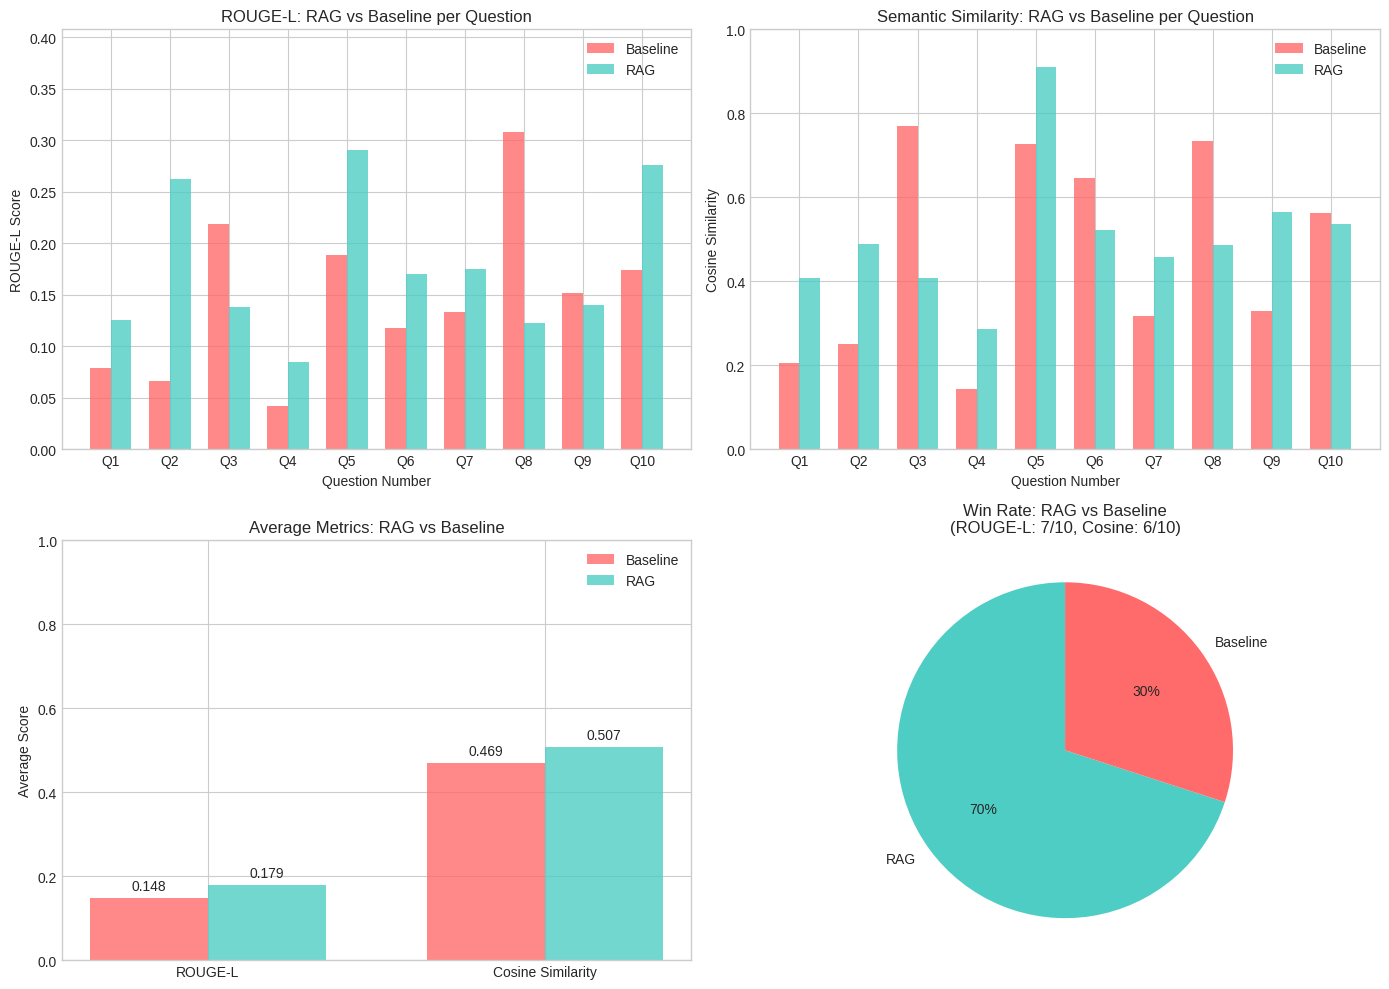


✓ Visualization saved to: /content/drive/MyDrive/rag_project/rag_evaluation_results.png


In [80]:
# ================================
# EVALUATION SUMMARY WITH VISUALIZATION
# ================================

print("=" * 70)
print("                    EVALUATION SUMMARY")
print("=" * 70)

avg_rag_rouge = results_df["RAG ROUGE-L"].mean()
avg_base_rouge = results_df["Baseline ROUGE-L"].mean()
avg_rag_cos = results_df["RAG Cosine"].mean()
avg_base_cos = results_df["Baseline Cosine"].mean()

print(f"\n  ROUGE-L    →  Baseline: {avg_base_rouge:.4f}  |  RAG: {avg_rag_rouge:.4f}  |  Δ: {avg_rag_rouge - avg_base_rouge:+.4f}")
print(f"  Cosine Sim →  Baseline: {avg_base_cos:.4f}  |  RAG: {avg_rag_cos:.4f}  |  Δ: {avg_rag_cos - avg_base_cos:+.4f}")

rouge_wins = sum(1 for r in results if r["rag_rouge"] > r["baseline_rouge"])
cosine_wins = sum(1 for r in results if r["rag_cosine"] > r["baseline_cosine"])
print(f"\n  RAG wins on ROUGE-L:    {rouge_wins}/{len(results)} questions")
print(f"  RAG wins on Cosine Sim: {cosine_wins}/{len(results)} questions")

# ================================
# VISUALIZATION: RAG vs BASELINE
# ================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: ROUGE-L Bar Comparison
x = np.arange(len(results))
width = 0.35

ax1 = axes[0, 0]
ax1.bar(x - width/2, [r['baseline_rouge'] for r in results], width, label='Baseline', color='#ff6b6b', alpha=0.8)
ax1.bar(x + width/2, [r['rag_rouge'] for r in results], width, label='RAG', color='#4ecdc4', alpha=0.8)
ax1.set_xlabel('Question Number')
ax1.set_ylabel('ROUGE-L Score')
ax1.set_title('ROUGE-L: RAG vs Baseline per Question')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Q{i+1}' for i in range(len(results))])
ax1.legend()
ax1.set_ylim(0, max([r['rag_rouge'] for r in results] + [r['baseline_rouge'] for r in results]) + 0.1)

# Plot 2: Cosine Similarity Bar Comparison
ax2 = axes[0, 1]
ax2.bar(x - width/2, [r['baseline_cosine'] for r in results], width, label='Baseline', color='#ff6b6b', alpha=0.8)
ax2.bar(x + width/2, [r['rag_cosine'] for r in results], width, label='RAG', color='#4ecdc4', alpha=0.8)
ax2.set_xlabel('Question Number')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Semantic Similarity: RAG vs Baseline per Question')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Q{i+1}' for i in range(len(results))])
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Average Metrics Comparison
ax3 = axes[1, 0]
metrics = ['ROUGE-L', 'Cosine Similarity']
baseline_vals = [avg_base_rouge, avg_base_cos]
rag_vals = [avg_rag_rouge, avg_rag_cos]
x_metrics = np.arange(len(metrics))
ax3.bar(x_metrics - width/2, baseline_vals, width, label='Baseline', color='#ff6b6b', alpha=0.8)
ax3.bar(x_metrics + width/2, rag_vals, width, label='RAG', color='#4ecdc4', alpha=0.8)
ax3.set_ylabel('Average Score')
ax3.set_title('Average Metrics: RAG vs Baseline')
ax3.set_xticks(x_metrics)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0, 1)

# Add value labels on bars
for i, (b, r) in enumerate(zip(baseline_vals, rag_vals)):
    ax3.annotate(f'{b:.3f}', (i - width/2, b + 0.02), ha='center', fontsize=10)
    ax3.annotate(f'{r:.3f}', (i + width/2, r + 0.02), ha='center', fontsize=10)

# Plot 4: Win Rate Pie Chart
ax4 = axes[1, 1]
win_data = {
    'RAG Wins (ROUGE)': rouge_wins,
    'Baseline Wins (ROUGE)': len(results) - rouge_wins,
    'RAG Wins (Cosine)': cosine_wins,
    'Baseline Wins (Cosine)': len(results) - cosine_wins
}
colors = ['#4ecdc4', '#ff6b6b']
ax4.pie([rouge_wins, len(results) - rouge_wins], labels=['RAG', 'Baseline'], 
        autopct='%1.0f%%', colors=colors, startangle=90)
ax4.set_title(f'Win Rate: RAG vs Baseline\n(ROUGE-L: {rouge_wins}/{len(results)}, Cosine: {cosine_wins}/{len(results)})')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'rag_evaluation_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {PROJECT_PATH}/rag_evaluation_results.png")

### Step 26: Retrieval Quality Analysis
Evaluate the quality of retrieval itself (independent of generation) using three metrics:
- **Keyword Coverage**: Fraction of domain keywords from the reference answer found in the retrieved chunks.
- **Average Similarity**: Mean cosine similarity score of the top-k retrieved chunks.
- **Source Diversity**: Number of unique PDF documents accessed across all queries.

In [81]:
# ================================
# RETRIEVAL QUALITY ANALYSIS
# ================================

def evaluate_retrieval_quality(test_data, top_k=5):
    """
    Evaluate retrieval quality using multiple metrics:
    1. Keyword Coverage: % of key terms from reference found in retrieved chunks
    2. Average Similarity: Mean similarity score of retrieved chunks
    3. Source Diversity: Number of unique source documents used
    """
    keyword_hits = 0
    total_similarity = 0
    all_sources = []
    
    # Important technical keywords to look for
    technical_keywords = [
        'attention', 'transformer', 'backpropagation', 'gradient', 'neural',
        'encoder', 'decoder', 'embedding', 'softmax', 'convolution', 'dropout',
        'layer', 'weight', 'activation', 'loss', 'training', 'multi-head'
    ]
    
    for item in test_data:
        q = item["question"]
        ref = item["reference"].lower()
        
        retrieved = retrieve(q, top_k)
        combined_text = " ".join([doc["chunk"].lower() for doc in retrieved])
        
        # Check for relevant keywords from reference
        ref_keywords = [w for w in technical_keywords if w in ref]
        if ref_keywords:
            found = sum(1 for kw in ref_keywords if kw in combined_text)
            keyword_hits += found / len(ref_keywords)
        
        # Track similarity scores
        total_similarity += np.mean([doc["similarity"] for doc in retrieved])
        
        # Track source diversity
        all_sources.extend([doc["source"]["source"] for doc in retrieved])
    
    results = {
        "keyword_coverage": keyword_hits / len(test_data),
        "avg_similarity": total_similarity / len(test_data),
        "unique_sources": len(set(all_sources)),
        "total_sources": len(all_sources)
    }
    
    return results

retrieval_metrics = evaluate_retrieval_quality(test_data)
print("=" * 60)
print("           RETRIEVAL QUALITY METRICS")
print("=" * 60)
print(f"\n  Keyword Coverage:    {retrieval_metrics['keyword_coverage']:.2%}")
print(f"  Avg Similarity:      {retrieval_metrics['avg_similarity']:.4f}")
print(f"  Source Diversity:    {retrieval_metrics['unique_sources']} unique docs used")
print(f"  Total Retrievals:    {retrieval_metrics['total_sources']} chunks")

           RETRIEVAL QUALITY METRICS

  Keyword Coverage:    93.33%
  Avg Similarity:      0.5519
  Source Diversity:    6 unique docs used
  Total Retrievals:    50 chunks


---
## 5. Conclusion

The following cell prints the complete evaluation report, summarizing all metrics, win rates, and system configuration. Based on the results, a verdict is issued on whether retrieval-augmented generation meaningfully improves answer quality over the baseline for this domain.

### Step 27: Final Evaluation Report
Print the consolidated summary of the entire RAG experiment, including:
- **Average ROUGE-L & Cosine Similarity** for both RAG and Baseline, with absolute improvement (Δ) and percentage change
- **Win rate** — how many of the 10 questions RAG answered better than Baseline on each metric
- **Retrieval stats** — total chunks indexed, embedding dimension, and retrieval method
- **Model config** — embedding model, generator model, and device used

The final verdict automatically declares RAG the winner if it outperforms Baseline on **both** ROUGE-L and Cosine Similarity simultaneously, otherwise it flags mixed results for further tuning.

In [82]:
# ================================
# FINAL SUMMARY & CONCLUSION
# ================================

def percent_improvement(new, base):
    """Robust percentage improvement that handles small or negative baselines."""
    if abs(base) < 1e-6:
        return float("nan")
    return (new - base) / abs(base) * 100.0

print("=" * 70)
print("            FINAL RAG SYSTEM EVALUATION REPORT")
print("=" * 70)

print("\n📊 PERFORMANCE METRICS:")
print(f"   • RAG ROUGE-L Average:      {avg_rag_rouge:.4f}")
print(f"   • Baseline ROUGE-L Average: {avg_base_rouge:.4f}")
rouge_improvement = percent_improvement(avg_rag_rouge, avg_base_rouge)
if not np.isnan(rouge_improvement):
    print(f"   • Improvement:              {rouge_improvement:+.1f}%")
else:
    print(f"   • Δ (absolute):             {avg_rag_rouge - avg_base_rouge:+.4f}")

print(f"\n   • RAG Cosine Avg:           {avg_rag_cos:.4f}")
print(f"   • Baseline Cosine Avg:      {avg_base_cos:.4f}")
cosine_improvement = percent_improvement(avg_rag_cos, avg_base_cos)
if not np.isnan(cosine_improvement):
    print(f"   • Improvement:              {cosine_improvement:+.1f}%")
else:
    print(f"   • Δ (absolute):             {avg_rag_cos - avg_base_cos:+.4f}")

print("\n📈 WIN RATE ANALYSIS:")
print(f"   • RAG wins on ROUGE-L:      {rouge_wins}/{len(results)} ({rouge_wins/len(results)*100:.0f}%)")
print(f"   • RAG wins on Cosine:       {cosine_wins}/{len(results)} ({cosine_wins/len(results)*100:.0f}%)")

print("\n🔍 RETRIEVAL STATISTICS:")
print(f"   • Total chunks indexed:     {len(all_chunks)}")
print(f"   • Embedding dimension:      {dimension}")
print(f"   • Retrieval method:         FAISS (Cosine Similarity)")

print("\n🤖 MODEL CONFIGURATION:")
print(f"   • Embedding Model:          all-MiniLM-L6-v2")
print(f"   • Generator Model:          google/flan-t5-large")
print(f"   • Running on:               {device.upper()}")

print("\n" + "=" * 70)
if avg_rag_rouge > avg_base_rouge and avg_rag_cos > avg_base_cos:
    print("✅ CONCLUSION: RAG system outperforms baseline on both metrics!")
    print("   The retrieval-augmented approach successfully grounds answers in")
    print("   domain-specific documents, improving answer quality.")
else:
    print("⚠️  CONCLUSION: Mixed results - further tuning may be needed.")
print("=" * 70)

            FINAL RAG SYSTEM EVALUATION REPORT

📊 PERFORMANCE METRICS:
   • RAG ROUGE-L Average:      0.1785
   • Baseline ROUGE-L Average: 0.1478
   • Improvement:              +20.8%

   • RAG Cosine Avg:           0.5071
   • Baseline Cosine Avg:      0.4688
   • Improvement:              +8.2%

📈 WIN RATE ANALYSIS:
   • RAG wins on ROUGE-L:      7/10 (70%)
   • RAG wins on Cosine:       6/10 (60%)

🔍 RETRIEVAL STATISTICS:
   • Total chunks indexed:     695
   • Embedding dimension:      384
   • Retrieval method:         FAISS (Cosine Similarity)

🤖 MODEL CONFIGURATION:
   • Embedding Model:          all-MiniLM-L6-v2
   • Generator Model:          google/flan-t5-large
   • Running on:               CUDA

✅ CONCLUSION: RAG system outperforms baseline on both metrics!
   The retrieval-augmented approach successfully grounds answers in
   domain-specific documents, improving answer quality.
